In [26]:
import json
import matplotlib.pyplot as plt
import scipy
import numpy as np
import glob
import seaborn as sns

from PIL import Image
from scipy import ndimage


from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

from keras import models
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import load_model
from keras.optimizers import RMSprop

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random



%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.mymods import Vis_results2, Vis_results_test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Loading in final model and its history
with open('../../src/history_mod1.json') as f:
    history = json.load(f)
model = load_model('../../src/best_weights_mod1.hdf5')

In [13]:
# Constants across all models
train_dir = '../../src/data2/train'
val_dir = '../../src/data2/val'
test_dir = '../../src/data2/test'

num_of_test_samples = len(glob.glob('../../src/data2/test/*/*.jpg'))
batch_size = 64
target_size = (176, 208)

# Rescales the pixel values between 0 and 1 so keras can work with it
# Not going to use image Augmentation as results were high enough without
dagenerator = ImageDataGenerator(rescale=1./255)

train_generator  = dagenerator.flow_from_directory(directory = train_dir,
                                                   target_size = target_size,
                                                   batch_size = batch_size)

val_generator = dagenerator.flow_from_directory(directory = val_dir,
                                                  target_size = target_size,
                                                  shuffle = False,
                                                  batch_size = batch_size)

test_generator = dagenerator.flow_from_directory(directory = test_dir,
                                                  target_size = target_size,
                                                  shuffle = False,
                                                  batch_size = num_of_test_samples)

Found 4479 images belonging to 4 classes.
Found 959 images belonging to 4 classes.
Found 961 images belonging to 4 classes.


In [154]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 174, 206, 10)      280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 87, 103, 10)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 101, 20)       1820      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 50, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 48, 20)        3620      
_________________________________________________________________
flatten (Flatten)            (None, 38400)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

-----------------------Val Classification Report-------------------
              precision    recall  f1-score   support

        Mild       0.98      0.99      0.98       134
    Moderate       1.00      1.00      1.00         9
        None       0.99      0.98      0.98       480
   Very Mild       0.97      0.98      0.97       336

    accuracy                           0.98       959
   macro avg       0.98      0.99      0.98       959
weighted avg       0.98      0.98      0.98       959

------------------------Val Confusion Matrix---------------------------


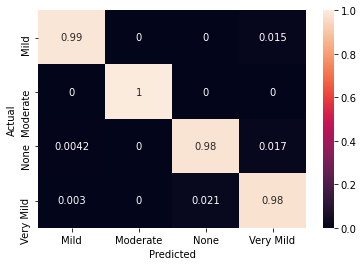

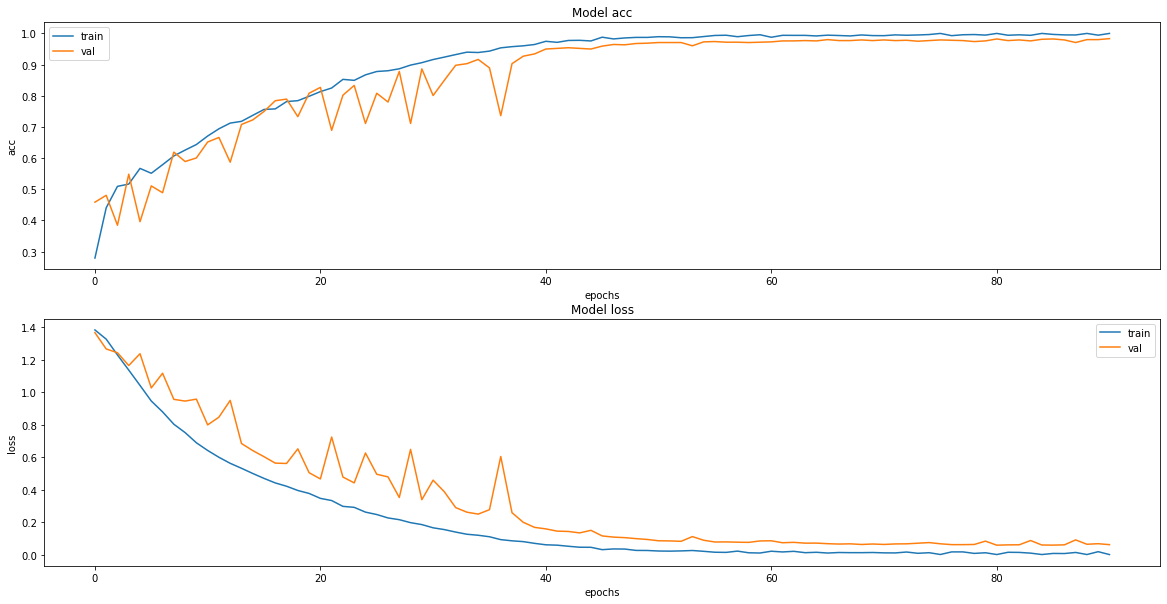

In [153]:
Vis_results2(model, history, val_generator, val_generator.n, batch_size)

-----------------------Test Classification Report-------------------
              precision    recall  f1-score   support

        Mild       0.98      0.94      0.96       135
    Moderate       1.00      1.00      1.00        11
        None       0.99      0.96      0.98       480
   Very Mild       0.94      0.99      0.96       335

    accuracy                           0.97       961
   macro avg       0.98      0.97      0.97       961
weighted avg       0.97      0.97      0.97       961

------------------------Test Confusion Matrix---------------------------


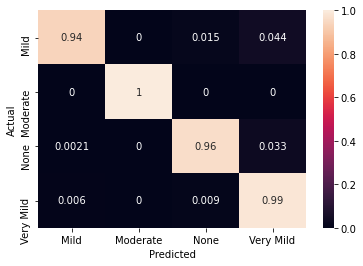

In [149]:
y_pred, Y_pred = Vis_results_test(model, history, test_generator)

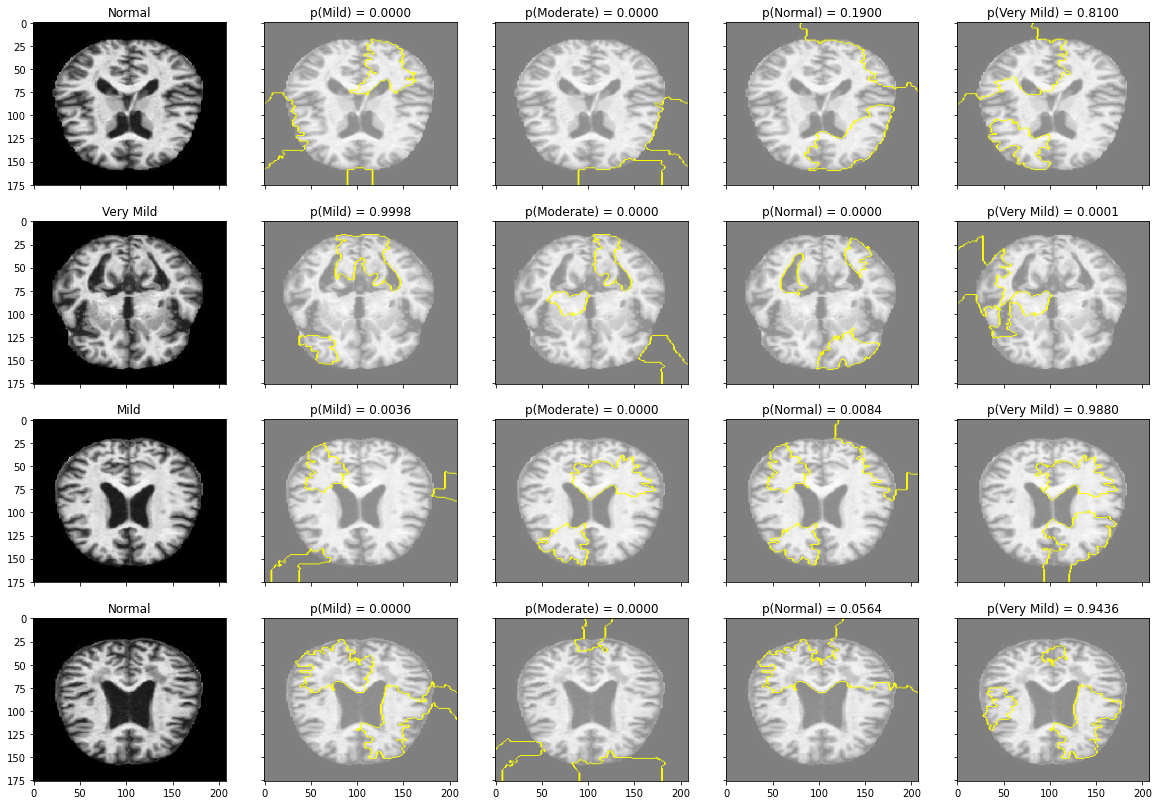

In [150]:
explainer = lime_image.LimeImageExplainer(random_state=42)



ncols = 5
nrows = 4 

a, b = test_generator[0] # a is now equal to an array of all the images in the test generator
incorrects = np.nonzero(y_pred != test_generator.classes)[0] # list of all indecies our model got wrong 
indecies = np.random.choice(incorrects, ncols) # Random selecting of wrongly predicted images. ncols is the how many images
class_name = ['Mild', 'Moderate', 'Normal', 'Very Mild']


fig, ax = plt.subplots(nrows, ncols, sharex='col', sharey='row')
fig.set_figwidth(20)
fig.set_figheight(14)


for j in range(nrows):
    explanation = explainer.explain_instance(a[indecies][j], 
                                             model.predict, 
                                             top_labels=4, hide_color=0, num_samples=200, 
                                             random_seed=42)
    ax[j,0].imshow(a[indecies][j])
    ax[j,0].set_title(class_name[test_generator.classes[indecies][j]])
    for i in range(ncols - 1):
        temp, mask = explanation.get_image_and_mask(i, positive_only=True, 
                                                    num_features=3, hide_rest=False)
        ax[j,i+1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
        ax[j,i+1].set_title('p({}) = {:.4f}'.format(class_name[i], Y_pred[indecies[j]][i]))

plt.savefig(f'../report/figures/Lime_wrong_preds', dpi = 100)

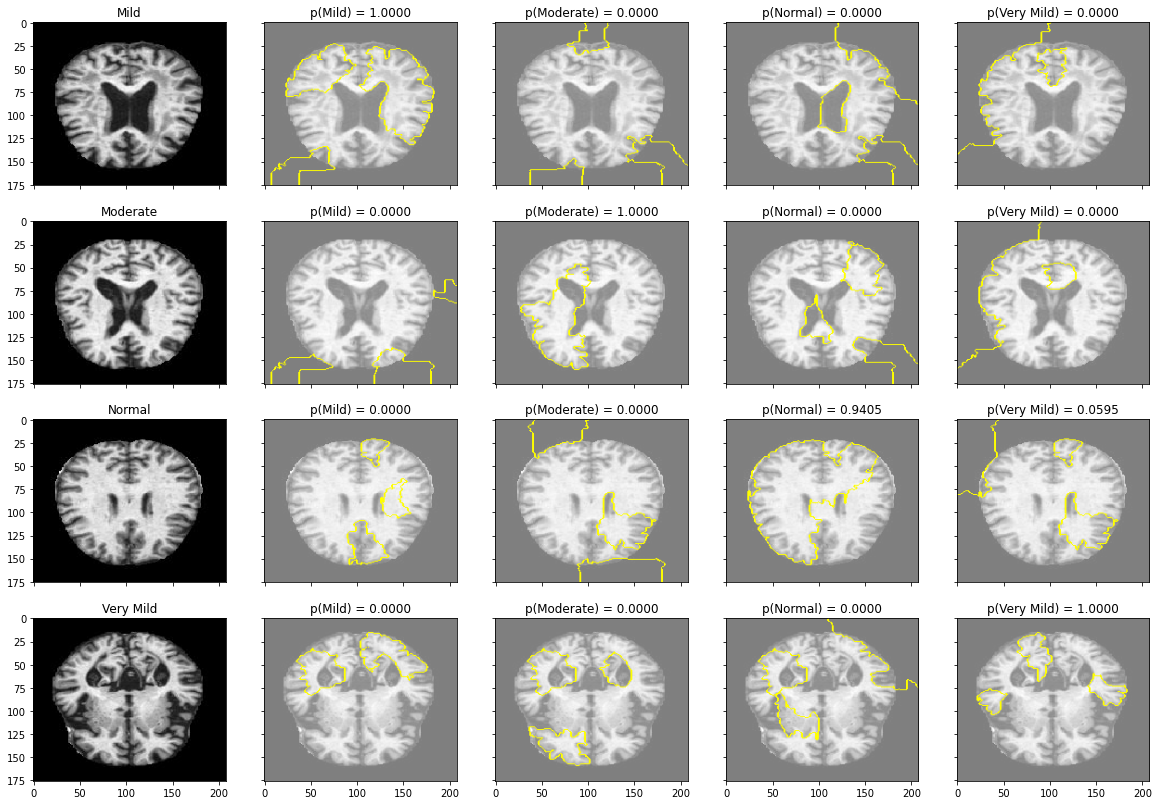

In [151]:

ncols = 5
nrows = 4 

corrects = np.nonzero(y_pred == test_generator.classes)[0] # list of all indecies our model got wrong 
correct_ind = corrects[[1,136,200,800]] # Random selecting of correct predicted images. ncols is the how many images


fig, ax = plt.subplots(nrows, ncols, sharex='col', sharey='row')
fig.set_figwidth(20)
fig.set_figheight(14)


for j in range(nrows):
    explanation = explainer.explain_instance(a[correct_ind][j], 
                                             model.predict, 
                                             top_labels=4, hide_color=0, num_samples=200, 
                                             random_seed=42)
    ax[j,0].imshow(a[correct_ind][j])
    ax[j,0].set_title(class_name[test_generator.classes[correct_ind][j]])
    for i in range(ncols - 1):
        temp, mask = explanation.get_image_and_mask(i, positive_only=True, 
                                                    num_features=3, hide_rest=False)
        ax[j,i+1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
        ax[j,i+1].set_title('p({}) = {:.4f}'.format(class_name[i], Y_pred[correct_ind[j]][i]))

plt.savefig(f'../report/figures/Lime_correct_preds', dpi = 100)